In [1]:
!pip install transformers torch pinecone-client pandas scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.8/244.8 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 5.7 MB/s eta 0:00:00


In [2]:
# Required imports
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pinecone
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Download NLTK stopwords
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

# Preprocessing functions
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
def clean_text(text):
    """Cleans the input text by removing special characters and stopwords."""
    text = text.lower()  # Lowercase the text
    text = REPLACE_BY_SPACE_RE.sub(' ', text)  # Replace unwanted symbols with space
    text = BAD_SYMBOLS_RE.sub('', text)  # Remove unwanted symbols
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)  # Remove stopwords
    return text


In [5]:

def plot_class(df):
    """Plots the distribution of the classes."""
    specified_tags = ['Class A', 'Class B', 'Class C', 'Class D']
    df['class'].value_counts().plot(kind='bar')
    plt.xticks(ticks=np.arange(len(specified_tags)), labels=specified_tags)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.title("Class Distribution")
    plt.show()

In [6]:
def load_data(data_file):
    """Loads and preprocesses the data."""
    df = pd.read_csv(data_file)
    specified_tags = ['Class A', 'Class B', 'Class C', 'Class D']
    df = df[df['class'].isin(specified_tags)]  # Filter specified classes
    df['device'] = df['device'].apply(clean_text)  # Clean the text
    plot_class(df)
    
    # Convert texts and labels
    texts = df['device'].tolist()
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(df['class'])
    
    return texts, labels

In [7]:
from pinecone import Pinecone

pc = Pinecone(api_key="fb2d9eb8-000e-4f67-9017-1b81a94359cc")
index = pc.Index("mdc")

In [10]:
# Load BERT model and tokenizer
model_name = "bert-base-uncased"  # Use a BERT variant from Hugging Face
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [11]:

# Function to compute sentence embeddings
def get_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)
    embeddings = torch.mean(outputs.last_hidden_state, dim=1).detach().numpy().squeeze()  # Mean pooling
    return embeddings


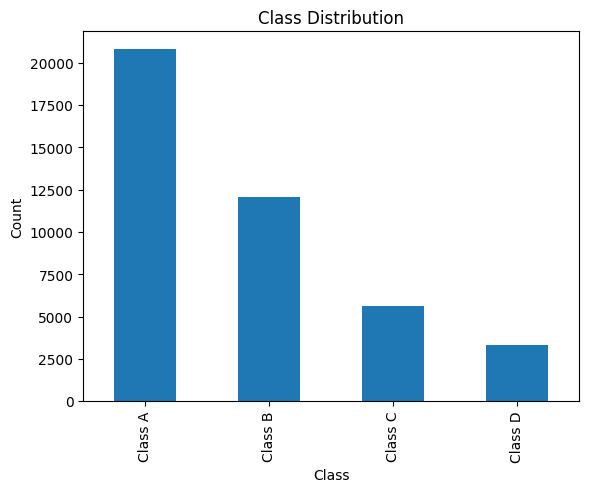

In [12]:
# Load and preprocess the dataset
data_file = "/kaggle/input/mdc-fold/mdc_data.csv" # Replace with the correct dataset path
texts, labels = load_data(data_file)

In [13]:
# Split into training and testing
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)


In [14]:
from tqdm import tqdm  # Import tqdm for progress bar

# Insert training data into Pinecone with embeddings and labels using tqdm for progress
for text, label in tqdm(zip(train_texts, train_labels), total=len(train_texts), desc="Inserting into Pinecone"):
    embedding = get_embeddings(text)
    index.upsert([(str(hash(text)), embedding.tolist(), {"label": str(label)})])


Inserting into Pinecone: 100%|██████████| 33467/33467 [2:09:16<00:00,  4.31it/s]  


In [19]:
# Function to predict the label using majority pooling
def predict_label(test_text):
    embedding = get_embeddings(test_text)
    query_result = index.query(vector=embedding.tolist(), top_k=5, include_metadata=True)
    
    # Retrieve labels of nearest neighbors
    labels = [match['metadata']['label'] for match in query_result['matches']]
    
    # Perform majority pooling
    most_common_label = Counter(labels).most_common(1)[0][0]
    return most_common_label


In [21]:
from tqdm import tqdm  # Import tqdm for progress bar
# Test the model on the test dataset
correct = 0
for text, label in tqdm(zip(test_texts, test_labels), total=len(test_texts)):
    predicted_label = predict_label(text)
    if predicted_label == str(label):
        correct += 1

# Compute accuracy
accuracy = correct / len(test_texts)
print(f"Accuracy: {accuracy * 100:.2f}%")

100%|██████████| 8367/8367 [26:55<00:00,  5.18it/s]

Accuracy: 86.81%
